In [ ]:
# ======================================
# 1️⃣ Imports
# ======================================
import os, shutil, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import kagglehub

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy


In [ ]:
# ======================================
# 2️⃣ Download Dataset
# ======================================
print("Downloading dataset...")
DATASET_PATH = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")
print("Dataset path:", DATASET_PATH)

IMAGES_PATH, ANNOS_PATH = None, None
for root, dirs, files in os.walk(DATASET_PATH):
    if "cars_train_annos.mat" in files:
        ANNOS_PATH = os.path.join(root, "cars_train_annos.mat")
    if os.path.basename(root) == "cars_train":
        IMAGES_PATH = root

print("Images path:", IMAGES_PATH)
print("Annotations path:", ANNOS_PATH)


100%|██████████| 1.82G/1.82G [00:47<00:00, 41.6MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1
Images path: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_train/cars_train
Annotations path: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/car_devkit/devkit/cars_train_annos.mat


In [ ]:
# ======================================
# 3️⃣ Load Annotations
# ======================================
annos = scipy.io.loadmat(ANNOS_PATH)
annotations = annos["annotations"][0]

class_dict = {}
for ann in annotations:
    img_name = ann[5][0]
    class_id = int(ann[4][0][0])
    class_dict.setdefault(class_id, []).append(img_name)

print("Total classes:", len(class_dict))


Total classes: 196


In [ ]:
# ======================================
# 4️⃣ Select Top 40 Classes
# ======================================
# ترتيب الكلاسات حسب عدد الصور
sorted_classes = sorted(class_dict.items(), key=lambda x: len(x[1]), reverse=True)
selected_classes = [cls for cls, imgs in sorted_classes[:40]]

OUTPUT_PATH = "/kaggle/working/cars_40_classes"
os.makedirs(OUTPUT_PATH, exist_ok=True)

missing = 0
for cls in selected_classes:
    class_folder = os.path.join(OUTPUT_PATH, f"class_{cls}")
    os.makedirs(class_folder, exist_ok=True)
    for img in class_dict[cls]:
        src = os.path.join(IMAGES_PATH, img)
        dst = os.path.join(class_folder, img)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            missing += 1

print("✅ Created dataset with 40 classes at:", OUTPUT_PATH)
print("⚠️ Missing images:", missing)


✅ Created dataset with 40 classes at: /kaggle/working/cars_40_classes
⚠️ Missing images: 0


In [ ]:
# ======================================
# 5️⃣ Build DataFrame
# ======================================
DATA_PATH = OUTPUT_PATH
data = []
for cls in sorted(os.listdir(DATA_PATH)):
    if not cls.startswith("class_"):
        continue
    cls_path = os.path.join(DATA_PATH, cls)
    for img in os.listdir(cls_path):
        if img.lower().endswith(('.jpg','.jpeg','.png')):
            data.append({"filename": os.path.join(cls_path, img), "label": cls})

df = pd.DataFrame(data)
print("Total images:", len(df))
print("Total classes:", df["label"].nunique())


Total images: 1847
Total classes: 40


In [ ]:
# ======================================
# 6️⃣ Train / Validation Split
# ======================================
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

IMG_SIZE = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
print("NUM_CLASSES:", NUM_CLASSES)


Found 1477 validated image filenames belonging to 40 classes.
Found 370 validated image filenames belonging to 40 classes.
NUM_CLASSES: 40


EfficientNetB0 model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ======================================
# 1️⃣ Load pre-trained EfficientNetB0
# ======================================
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base_model initially
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Prevent overfitting
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 299, 299,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 299, 299,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,100,811 (15.64 MB)

 Trainable params: 51,240 (200.16 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
]


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # Phase 1
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0544 - loss: 3.6584 - top_k_categorical_accuracy: 0.2040

47/47 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.0551 - loss: 3.6550 - top_k_categorical_accuracy: 0.2058 - val_accuracy: 0.2108 - val_loss: 3.0805 - val_top_k_categorical_accuracy: 0.5784 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.2594 - loss: 2.9663 - top_k_categorical_accuracy: 0.5939

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 915ms/step - accuracy: 0.2597 - loss: 2.9647 - top_k_categorical_accuracy: 0.5944 - val_accuracy: 0.3676 - val_loss: 2.6675 - val_top_k_categorical_accuracy: 0.7514 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.3919 - loss: 2.5643 - top_k_categorical_accuracy: 0.7539

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 905ms/step - accuracy: 0.3920 - loss: 2.5638 - top_k_categorical_accuracy: 0.7539 - val_accuracy: 0.4189 - val_loss: 2.4063 - val_top_k_categorical_accuracy: 0.7811 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.4506 - loss: 2.3013 - top_k_categorical_accuracy: 0.8132

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 915ms/step - accuracy: 0.4509 - loss: 2.3006 - top_k_categorical_accuracy: 0.8131 - val_accuracy: 0.4622 - val_loss: 2.2130 - val_top_k_categorical_accuracy: 0.8027 - learning_rate: 0.0010
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5135 - loss: 2.0898 - top_k_categorical_accuracy: 0.8522

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 900ms/step - accuracy: 0.5135 - loss: 2.0893 - top_k_categorical_accuracy: 0.8525 - val_accuracy: 0.5270 - val_loss: 2.0519 - val_top_k_categorical_accuracy: 0.8351 - learning_rate: 0.0010
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.5565 - loss: 1.9475 - top_k_categorical_accuracy: 0.8864

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 894ms/step - accuracy: 0.5567 - loss: 1.9470 - top_k_categorical_accuracy: 0.8863 - val_accuracy: 0.5405 - val_loss: 1.9545 - val_top_k_categorical_accuracy: 0.8297 - learning_rate: 0.0010
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 897ms/step - accuracy: 0.6027 - loss: 1.7995 - top_k_categorical_accuracy: 0.8908 - val_accuracy: 0.5351 - val_loss: 1.8518 - val_top_k_categorical_accuracy: 0.8486 - learning_rate: 0.0010
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.6343 - loss: 1.6700 - top_k_categorical_accuracy: 0.9059

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 899ms/step - accuracy: 0.6343 - loss: 1.6698 - top_k_categorical_accuracy: 0.9060 - val_accuracy: 0.5838 - val_loss: 1.7721 - val_top_k_categorical_accuracy: 0.8514 - learning_rate: 0.0010
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 907ms/step - accuracy: 0.6546 - loss: 1.5447 - top_k_categorical_accuracy: 0.9129 - val_accuracy: 0.5649 - val_loss: 1.7021 - val_top_k_categorical_accuracy: 0.8595 - learning_rate: 0.0010
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 879ms/step - accuracy: 0.6452 - loss: 1.5231 - top_k_categorical_accuracy: 0.9152 - val_accuracy: 0.5703 - val_loss: 1.6611 - val_top_k_categorical_accuracy: 0.8459 - learning_rate: 0.0010


In [ ]:
# Unfreeze all layers for fine-tuning
base_model.trainable = True

# Compile with lower LR
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

# Continue training
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,   # Phase 2
    callbacks=callbacks
)


Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.3376 - loss: 2.5616 - top_k_categorical_accuracy: 0.6898 - val_accuracy: 0.4973 - val_loss: 1.7546 - val_top_k_categorical_accuracy: 0.8297 - learning_rate: 1.0000e-04
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.5974 - loss: 1.7906 - top_k_categorical_accuracy: 0.8679

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 966ms/step - accuracy: 0.5978 - loss: 1.7882 - top_k_categorical_accuracy: 0.8684 - val_accuracy: 0.6054 - val_loss: 1.4189 - val_top_k_categorical_accuracy: 0.8865 - learning_rate: 1.0000e-04
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.7085 - loss: 1.3021 - top_k_categorical_accuracy: 0.9359

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 970ms/step - accuracy: 0.7088 - loss: 1.3011 - top_k_categorical_accuracy: 0.9361 - val_accuracy: 0.6541 - val_loss: 1.2249 - val_top_k_categorical_accuracy: 0.9081 - learning_rate: 1.0000e-04
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.7892 - loss: 1.0448 - top_k_categorical_accuracy: 0.9517

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 942ms/step - accuracy: 0.7892 - loss: 1.0436 - top_k_categorical_accuracy: 0.9518 - val_accuracy: 0.7568 - val_loss: 0.9796 - val_top_k_categorical_accuracy: 0.9378 - learning_rate: 1.0000e-04
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.8499 - loss: 0.7702 - top_k_categorical_accuracy: 0.9843

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 974ms/step - accuracy: 0.8499 - loss: 0.7699 - top_k_categorical_accuracy: 0.9841 - val_accuracy: 0.7676 - val_loss: 0.8638 - val_top_k_categorical_accuracy: 0.9486 - learning_rate: 1.0000e-04
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8784 - loss: 0.6306 - top_k_categorical_accuracy: 0.9870

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 958ms/step - accuracy: 0.8786 - loss: 0.6301 - top_k_categorical_accuracy: 0.9871 - val_accuracy: 0.7946 - val_loss: 0.7718 - val_top_k_categorical_accuracy: 0.9622 - learning_rate: 1.0000e-04
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9155 - loss: 0.5149 - top_k_categorical_accuracy: 0.9936

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 963ms/step - accuracy: 0.9154 - loss: 0.5148 - top_k_categorical_accuracy: 0.9936 - val_accuracy: 0.8135 - val_loss: 0.6770 - val_top_k_categorical_accuracy: 0.9730 - learning_rate: 1.0000e-04
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9350 - loss: 0.4066 - top_k_categorical_accuracy: 0.9964

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 970ms/step - accuracy: 0.9349 - loss: 0.4069 - top_k_categorical_accuracy: 0.9964 - val_accuracy: 0.8270 - val_loss: 0.6101 - val_top_k_categorical_accuracy: 0.9811 - learning_rate: 1.0000e-04
Epoch 9/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9312 - loss: 0.3599 - top_k_categorical_accuracy: 0.9994

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 974ms/step - accuracy: 0.9313 - loss: 0.3597 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.8432 - val_loss: 0.5612 - val_top_k_categorical_accuracy: 0.9784 - learning_rate: 1.0000e-04
Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9657 - loss: 0.2931 - top_k_categorical_accuracy: 0.9959

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 948ms/step - accuracy: 0.9656 - loss: 0.2931 - top_k_categorical_accuracy: 0.9959 - val_accuracy: 0.8486 - val_loss: 0.5142 - val_top_k_categorical_accuracy: 0.9838 - learning_rate: 1.0000e-04
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9766 - loss: 0.2349 - top_k_categorical_accuracy: 1.0000

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 974ms/step - accuracy: 0.9764 - loss: 0.2349 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8514 - val_loss: 0.4883 - val_top_k_categorical_accuracy: 0.9838 - learning_rate: 1.0000e-04
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9756 - loss: 0.2146 - top_k_categorical_accuracy: 0.9989

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 972ms/step - accuracy: 0.9755 - loss: 0.2148 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.8676 - val_loss: 0.4668 - val_top_k_categorical_accuracy: 0.9865 - learning_rate: 1.0000e-04
Epoch 13/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9807 - loss: 0.1826 - top_k_categorical_accuracy: 0.9996

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 956ms/step - accuracy: 0.9807 - loss: 0.1825 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.8811 - val_loss: 0.4435 - val_top_k_categorical_accuracy: 0.9865 - learning_rate: 1.0000e-04
Epoch 14/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9815 - loss: 0.1550 - top_k_categorical_accuracy: 0.9993

47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 959ms/step - accuracy: 0.9815 - loss: 0.1549 - top_k_categorical_accuracy: 0.9993 - val_accuracy: 0.8865 - val_loss: 0.4322 - val_top_k_categorical_accuracy: 0.9838 - learning_rate: 1.0000e-04
Epoch 15/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 954ms/step - accuracy: 0.9848 - loss: 0.1489 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.8838 - val_loss: 0.4193 - val_top_k_categorical_accuracy: 0.9865 - learning_rate: 1.0000e-04


In [ ]:
# ======================================
# 8️⃣ Final Evaluation
# ======================================
val_loss, val_acc, val_top5 = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)
print("Validation Top-5 Accuracy:", val_top5)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.8961 - loss: 0.4166 - top_k_categorical_accuracy: 0.9865
Validation Accuracy: 0.8864864706993103
Validation Top-5 Accuracy: 0.9837837815284729


Prediction Function

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_car_image(img_pil):
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def get_car_prediction(img_pil, top_k=5):
    tensor_img = preprocess_car_image(img_pil)

    preds = model.predict(tensor_img)
    preds = preds[0]  # shape: (NUM_CLASSES,)

    sorted_idx = np.argsort(preds)[::-1]

    print("\n=== Prediction Summary ===")
    for rank, idx in enumerate(sorted_idx[:top_k], start=1):
        class_name = list(train_gen.class_indices.keys())[idx]
        confidence = preds[idx] * 100
        print(f"{rank}. {class_name} — {confidence:.2f}%")

    return sorted_idx[:top_k]


In [ ]:
from PIL import Image
import numpy as np

# Convert index → class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

def check_prediction(img_pil, true_label):
    # Resize + preprocess
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Predict
    preds = model.predict(img)[0]
    pred_idx = np.argmax(preds)
    pred_class = idx_to_class[pred_idx]
    confidence = preds[pred_idx] * 100

    # Compare
    is_correct = (pred_class == true_label)

    print("\n=== Prediction Check ===")
    print("True Label:      ", true_label)
    print("Predicted Label: ", pred_class)
    print(f"Confidence:       {confidence:.2f}%")
    print("Correct:", "YES " if is_correct else "NO ")

    return is_correct, pred_class, confidence


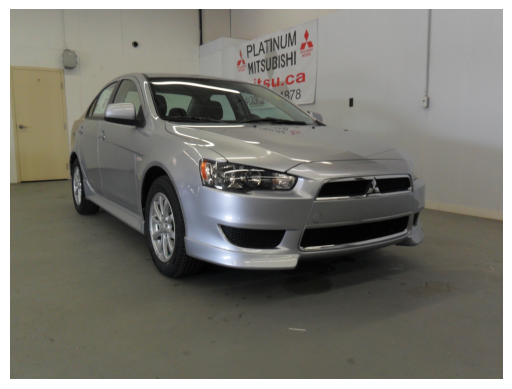

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

=== Prediction Check ===
True Label:       class_167
Predicted Label:  class_167
Confidence:       84.92%
Correct: YES 


(True, 'class_167', np.float32(84.923645))

In [ ]:
sample = val_df.sample(1).iloc[0]
img_path = sample["filename"]
true_label = sample["label"]

img_pil = Image.open(img_path).convert("RGB")

plt.imshow(img_pil)
plt.axis("off")
plt.show()

check_prediction(img_pil, true_label)


In [ ]:
history.history


{'accuracy': [0.08463101089000702,
  0.27014216780662537,
  0.3940419852733612,
  0.4651320278644562,
  0.511171281337738,
  0.5646581053733826,
  0.5917400121688843,
  0.6323629021644592,
  0.6452268362045288,
  0.6587677597999573],
 'loss': [3.49591326713562,
  2.890359878540039,
  2.544490337371826,
  2.267747640609741,
  2.0656371116638184,
  1.9205772876739502,
  1.7983728647232056,
  1.6625899076461792,
  1.5582209825515747,
  1.510556697845459],
 'top_k_categorical_accuracy': [0.2890995144844055,
  0.6174678206443787,
  0.7528774738311768,
  0.8124576807022095,
  0.8632363080978394,
  0.8808395266532898,
  0.8876100182533264,
  0.9119837284088135,
  0.9140148758888245,
  0.9207853674888611],
 'val_accuracy': [0.2108108103275299,
  0.3675675690174103,
  0.4189189076423645,
  0.46216216683387756,
  0.5270270109176636,
  0.5405405163764954,
  0.5351351499557495,
  0.5837838053703308,
  0.5648648738861084,
  0.570270299911499],
 'val_loss': [3.080500841140747,
  2.6675193309783936,


In [ ]:
history_ft.history


{'accuracy': [0.40081244707107544,
  0.614759624004364,
  0.7264725565910339,
  0.7894380688667297,
  0.8503723740577698,
  0.8882870674133301,
  0.9106296300888062,
  0.9275558590888977,
  0.937034547328949,
  0.961408257484436,
  0.9688557982444763,
  0.9688557982444763,
  0.9790115356445312,
  0.9823967218399048,
  0.9783344864845276],
 'loss': [2.370436906814575,
  1.6727848052978516,
  1.2550967931747437,
  0.986472487449646,
  0.7586768269538879,
  0.6058319807052612,
  0.5106380581855774,
  0.42130035161972046,
  0.35017481446266174,
  0.2943926751613617,
  0.23496390879154205,
  0.22445176541805267,
  0.17823003232479095,
  0.15048982203006744,
  0.1645827293395996],
 'top_k_categorical_accuracy': [0.7386594414710999,
  0.8909952640533447,
  0.9431279897689819,
  0.959377110004425,
  0.9749492406845093,
  0.9898442625999451,
  0.991875410079956,
  0.9945836067199707,
  0.997968852519989,
  0.997968852519989,
  1.0,
  0.9993229508399963,
  0.9993229508399963,
  0.999322950839996